# MOs demand utility
Based on cost amount - 5% top outliers to be dismissed

Import all then modules

In [1]:
import pandas as pd
from pandas import ExcelWriter
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import r2_score

Create a function to get the items based on two dataframes

In [2]:
def get_items(reported_df, mo_list, df_items):
    # Merge complete reported MO dataset with selected MO from sales
    reported_df['Ref order no'] = reported_df['Ref order no'].astype(str)
    mo_list['Ref order no'] = mo_list['Ref order no'].astype(str)
    df_filtered = pd.merge(reported_df, mo_list, on='Ref order no')
    
    # Change the items no format in order to not have merging problems
    df_filtered['Component no'] = df_filtered['Component no'].astype(str)
    df_items['Component no'] = df_items['Component no'].astype(str)
    
    # Merge the items to forecast with the MOs filtered dataset
    df = pd.merge(df_items, df_filtered, on = 'Component no')
    
    # Group, count and return final dataset
    df['Rep qty'] = df['Rep qty'].astype('int64')
    df_grouped = df.groupby(['Component no','Item name']).sum().sort_values(['Rep qty'], ascending = [False])
    df_grouped = df_grouped.drop(['Order no', 'Line no', 'Qty', 'Cost amount'], 1)
    
    return df_grouped

Import sales file. From this file we'll get the mo_list

In [3]:
sales_file = 'Sales.xlsx'
df_sales = pd.read_excel(sales_file, usecols = ['Customer name', 'Salesp.Order', 'Order no',
                                                'Line no', 'Item no', 'Item group descr', 'Qty',
                                                'Cost amount', 'Ref order no'])

Import reported MOs file

In [4]:
reported_file = 'MOs AHU.xlsx'
reported_df = pd.read_excel(reported_file, usecols = ['Ref order no', 'Component no',
                                                      'Component name', 'Rep qty'])

Import items to forecast

In [5]:
items_file = 'Items to forecast.xlsx'
df_items = pd.read_excel(items_file)

Filter the data for taking into account only the AHUs. Exclude DCC orders

In [6]:
df_ahu = df_sales[df_sales['Item group descr'] == '60302   Central units']
df_ahu = df_ahu[df_ahu['Salesp.Order'] != 'D645ANKO']

Create a pivot table for the cost amount

In [7]:
pivot_sales = pd.pivot_table(df_ahu, index = ['Order no', 'Customer name'],
                             values = ['Cost amount'], aggfunc=np.sum)
pivot_sales = pd.DataFrame(pivot_sales.to_records())

Get some stats about the cost

In [8]:
for i in range(0, 105, 5):
    value = pivot_sales['Cost amount'].quantile(i/100)
    print('Percentile ', i, ': ', value)

Percentile  0 :  79.228
Percentile  5 :  1073.116
Percentile  10 :  2112.2666
Percentile  15 :  2897.7214
Percentile  20 :  3559.6742
Percentile  25 :  4154.615
Percentile  30 :  4863.393
Percentile  35 :  5307.9346
Percentile  40 :  5940.527
Percentile  45 :  6668.6516
Percentile  50 :  7618.025
Percentile  55 :  8636.2528
Percentile  60 :  10157.8382
Percentile  65 :  11888.0626
Percentile  70 :  13693.2372
Percentile  75 :  16346.486
Percentile  80 :  20958.0126
Percentile  85 :  31424.8678
Percentile  90 :  42890.4262
Percentile  95 :  71808.4122
Percentile  100 :  354377.176


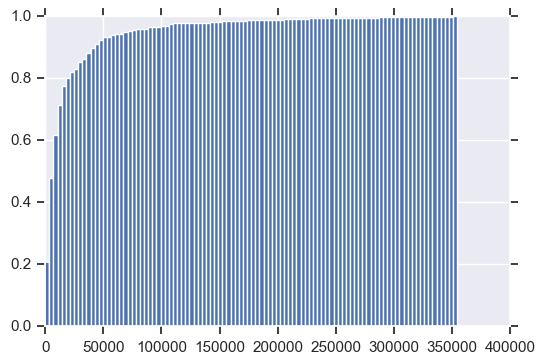

In [9]:
pivot_sales['Cost amount'].hist(cumulative=True, bins=100, normed=1)

Plot the histogram and check the outliers limits

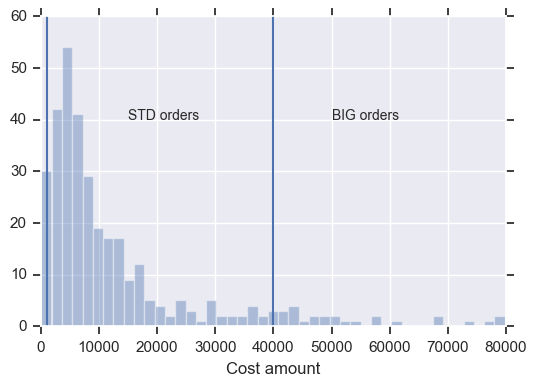

In [10]:
x = pivot_sales['Cost amount']
sns.distplot(x, bins=200, kde=False)
plt.xlim([0, 80000])
lower_limit , upper_limit = 1000, 40000
plt.axvline(lower_limit, color='b')
plt.axvline(upper_limit, color='b')
plt.annotate('STD orders', xy=(25, 50), xytext=(15000, 40))
plt.annotate('BIG orders', xy=(25, 50), xytext=(50000, 40))

Standard orders

In [11]:
co_df = pivot_sales[(pivot_sales['Cost amount'] > lower_limit) & 
                    (pivot_sales['Cost amount'] < upper_limit)]

total_cost = df_ahu['Cost amount'].sum(axis = 0, skipna = True)
cost_amount_std = co_df['Cost amount'].sum(axis = 0, skipna = True)

print('Cost amount of std orders: ', cost_amount_std)
print('Percentage of total cost amount: ', cost_amount_std/total_cost)

co_list = co_df.drop(['Customer name', 'Cost amount'], axis = 1)
mo_list = pd.merge(df_sales, co_list, on='Order no')
items = get_items(reported_df, mo_list, df_items)
name = 'Exported items from std orders.xlsx'
items.to_excel(name)

Cost amount of std orders:  2909550.8009999986
Percentage of total cost amount:  0.4375964292959371


Big orders

In [12]:
lower_limit , upper_limit = upper_limit, 500000
co_df = pivot_sales[(pivot_sales['Cost amount'] > lower_limit) & 
                    (pivot_sales['Cost amount'] < upper_limit)]

cost_amount_big = co_df['Cost amount'].sum(axis = 0, skipna = True)

print('Cost amount of big orders: ', cost_amount_big)
print('Percentage of total cost amount: ', cost_amount_big/total_cost)

co_list = co_df.drop(['Customer name', 'Cost amount'], axis = 1)
mo_list = pd.merge(df_sales, co_list, on='Order no')
items = get_items(reported_df, mo_list, df_items)
name = 'Exported items from big orders.xlsx'
items.to_excel(name)

Cost amount of big orders:  3731733.1060000006
Percentage of total cost amount:  0.5612526448102523
